# IBM- COURSERA DATA SCIENCE CAPSTONE PROJECT
## NEW  VEGAN RESTAURANT IN TORONTO

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
print('Packages installed  :)')

Packages installed  :)


### Scrapping data from Wikipedia to a Data Frame using Beautiful Soup Library

In [2]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

### Creating the data frame 

In [3]:
# Now we will read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())

In [4]:
df = pd.read_html(table_str)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Data cleaning

In [5]:
#Removing 'Not assigned'borough
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)

In [6]:
#Renaming Postal Code to eliminate thespace
df_dropna.rename(columns={'Postal Code' : 'PostalCode'}, inplace=True)

In [7]:
#Renaming Neighbourhood to Neighborhood
df_dropna.rename(columns={'Neighbourhood' : 'Neighborhood'}, inplace=True)

In [8]:
df = df_dropna

In [9]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [10]:
#Grouping all neighbourhoods with the same postal code
df_grouped = df.groupby(['Borough', 'PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

,Borough,PostalCode,Neighborhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


In [11]:
# We are going to check if we have eliminated all 'Not assigned' boroughs
df_grouped.loc[df_grouped['Borough'].isin(["Not assigned"])]

,Borough,PostalCode,Neighborhood


In [12]:
df = df_grouped

In [13]:
df.shape

(103, 3)

In [14]:
#We will reorder the Columns so the PostalCode appears first for easier readibility
df = df[['PostalCode', 'Borough', 'Neighborhood']]
df.head()

,PostalCode,Borough,Neighborhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,"North Toronto West, Lawrence Park"
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park, Summerhill East"


In [15]:
#For borough with neighborhood = Not assigned, neighborhood will be the same as borough
for index, row in df.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]
        
df.head()

,PostalCode,Borough,Neighborhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,"North Toronto West, Lawrence Park"
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park, Summerhill East"


### Getting the Latitude and Longitude data for each Postal Code

In [16]:
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merging the two data frames

In [17]:
# Merging the Data using the PostalCode column
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [18]:
# We are going to find out how many neighborhoods are in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [19]:
df_toronto = df
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [20]:
# We will create list with the Boroughs (to be used later)
boroughs = df_toronto['Borough'].unique().tolist()

In [21]:
boroughs

['Central Toronto',
 'Downtown Toronto',
 'East Toronto',
 'East York',
 'Etobicoke',
 'Mississauga',
 'North York',
 'Scarborough',
 'West Toronto',
 'York']

###  We will compare the number of neighborhoods in each borough  using a bar chart 

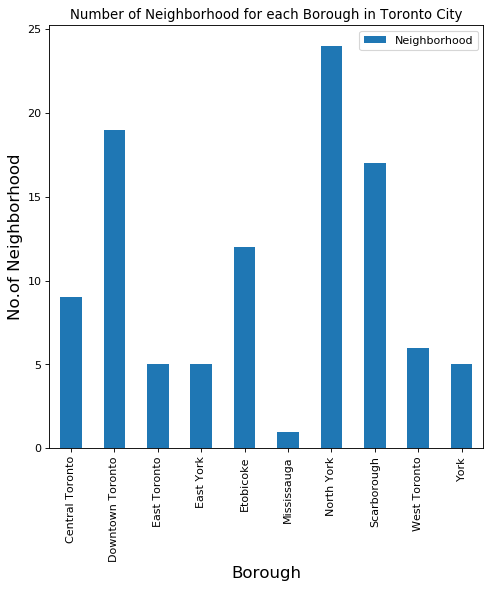

In [22]:
plt.figure(figsize=(7,7), dpi = 80)
# title
plt.title('Number of Neighborhood for each Borough in Toronto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df_toronto.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Using Folium  we will create a map of Toronto with neighborhoods superimposed on top

In [23]:
!pip install geopy
from geopy.geocoders import Nominatim 
#We need to define a user_agent. I will name my agent 'Toronto_explorer'
address = 'Toronto'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [24]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Now, we will use a colour-coded for each Neighborhood depending in what borough they are located in.

In [25]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [26]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

#### In this new map we see  very clearly  all the boroughs and their neighborhoods.

### We will use the Foursquare API to explore the neighborhoods and segment them

In [27]:
# define Foursquare Credentials and Version
CLIENT_ID = 'GO1IR2BUA2DBXVHD5SY44XYKQJEMDRF2G5R03ZQG4QUHC1AH' # my Foursquare ID
CLIENT_SECRET = 'QILYE2SBOJA0VZFE5H2CIPASH3PX2ISZN0GZJHMYYYUCL4WQ' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GO1IR2BUA2DBXVHD5SY44XYKQJEMDRF2G5R03ZQG4QUHC1AH
CLIENT_SECRET:QILYE2SBOJA0VZFE5H2CIPASH3PX2ISZN0GZJHMYYYUCL4WQ


In [28]:
#let´s explore venues 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'NeighborhoodLatitude', 
                  'NeighborhoodLongitude', 
                  'VenueName', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)

In [29]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [30]:
toronto_venues.head()

,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park


In [31]:
# We are going to find out how many venues are in each Neighborhood
toronto_venues.groupby('Neighborhood').count()

,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
...,...,...,...,...,...,...
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4
Woodbine Heights,9,9,9,9,9,9


In [32]:
#Let's find out how many unique categories can be curated from all the returned venues

print('There are {} uniques categories.'.format(len(toronto_venues['VenueCategory'].unique())))

There are 277 uniques categories.


In [33]:
# Let´s explore now which these unique venues categories are...
print("The Venue Categories are", toronto_venues['VenueCategory'].unique())

The Venue Categories are ['Park' 'Swim School' 'Bus Line' 'Breakfast Spot' 'Food & Drink Shop'
 'Department Store' 'Hotel' 'Sandwich Place' 'Gym / Fitness Center'
 'Dog Run' 'Dance Studio' 'Yoga Studio' 'Spa' 'Salon / Barbershop' 'Diner'
 'Clothing Store' 'Restaurant' 'Mexican Restaurant' 'Coffee Shop'
 'Chinese Restaurant' 'Sporting Goods Shop' 'Fast Food Restaurant' 'Café'
 'Ice Cream Shop' 'Furniture / Home Store' 'Bagel Shop' 'Dessert Shop'
 'Indian Restaurant' 'Pizza Place' 'Seafood Restaurant' 'Sushi Restaurant'
 'Italian Restaurant' 'Thai Restaurant' 'Brewery' 'Gym' 'Toy / Game Store'
 'Greek Restaurant' 'Gas Station' 'Farmers Market' 'Gourmet Shop'
 'Candy Store' 'Pharmacy' 'Indoor Play Area' 'Trail' 'Playground'
 'Liquor Store' 'Supermarket' 'American Restaurant' 'Pub'
 'Vietnamese Restaurant' 'Fried Chicken Joint' 'Bank' 'Light Rail Station'
 'Garden' 'Music Venue' 'Dive Bar' 'Jewelry Store'
 'Middle Eastern Restaurant' 'BBQ Joint' 'Burger Joint' 'Donut Shop'
 'History Museum

In [34]:
# Now we need to know if there is any Vegetarian or Vegan restaurant among these venues.
"Vegetarian / Vegan Restaurant" in toronto_venues['VenueCategory'].unique()

True

##### There are vegetarian/vegan restaurants in Toronto. We are going find out  more info about this  later because is something that will help us to decide where to open our  vegan restaurant.

### Now, we will  analyze each neighborhood

#### We will use the One hot encoding  technique in which Categorical Data is transformed into Numerical Data for Machine Learning algorithms.  For each of the neighbourhoods, individual venues were turned into the frequency at how many of those Venues were located in each neighbourhood.

In [35]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2167, 278)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Now, we will grouped those rows by Neighborhood and by taking the average of the frequency of occurrence of each Venue Category.
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head(50)

(96, 278)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,"Alderwood, Long Branch",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,Bayview Village,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,...,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
5,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.018182,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
8,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.058824,0.058824,0.058824,0.117647,0.117647,0.058824,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


##### We thing that for this project is interesting to consider other vegan restaurants that already exist in Toronto and also we are going to analayze the presence of a Yoga Studio as an  interesting venue to have near our restaurant. Let´s select only the Neighborhood, Vegan restaurants and yoga studio venues.

In [37]:
to_grouped_vegan_yoga=to_grouped[['Neighborhoods', 'Vegetarian / Vegan Restaurant','Yoga Studio']]
to_grouped_vegan_yoga.shape
to_grouped_vegan_yoga.head(50)

,Neighborhoods,Vegetarian / Vegan Restaurant,Yoga Studio
0,Agincourt,0.000000,0.000000
1,"Alderwood, Long Branch",0.000000,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000
3,Bayview Village,0.000000,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.000000
5,Berczy Park,0.018182,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000
8,"Business reply mail Processing Centre, South C...",0.000000,0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000


## Let´s see now the most common top venues for each Neighbourghood.

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = to_grouped['Neighborhoods']

for ind in np.arange(to_grouped.shape[0]):
    row_categories = to_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(96, 11)


,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Clothing Store,Event Space,Falafel Restaurant,Ethiopian Restaurant,Escape Room,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Coffee Shop,Pub,Pharmacy,Gym,Greek Restaurant,Discount Store,Department Store,Dessert Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Ice Cream Shop,Shopping Mall,Bridal Shop,Sandwich Place,Diner,Middle Eastern Restaurant,Restaurant
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Greek Restaurant,Thai Restaurant,Locksmith,Liquor Store,Comfort Food Restaurant,Juice Bar,Butcher
...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale West",Pizza Place,Grocery Store,Butcher,Coffee Shop,Pharmacy,Comic Shop,Diner,Ethiopian Restaurant,Escape Room,Electronics Store
92,Woburn,Coffee Shop,Mexican Restaurant,Korean BBQ Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
93,Woodbine Heights,Skating Rink,Curling Ice,Park,Intersection,Snack Place,Beer Store,Athletics & Sports,Dance Studio,Yoga Studio,Dog Run
94,York Mills West,Park,Convenience Store,Yoga Studio,Dumpling Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore


### Let´s explore the occurence of the Vegan/ Vegetarian restaurants

In [39]:
vegan = to_grouped[["Neighborhoods","Vegetarian / Vegan Restaurant"]]
vegan.head() #.head() shows the first five rows only

,Neighborhoods,Vegetarian / Vegan Restaurant
0,Agincourt,0.0
1,"Alderwood, Long Branch",0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0
3,Bayview Village,0.0
4,"Bedford Park, Lawrence Manor East",0.0


In [40]:
vegan = vegan.rename(columns={'Neighborhoods':'Neighborhood'})

In [41]:
vegan.head()

,Neighborhood,Vegetarian / Vegan Restaurant
0,Agincourt,0.0
1,"Alderwood, Long Branch",0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0
3,Bayview Village,0.0
4,"Bedford Park, Lawrence Manor East",0.0


In [42]:
vegan.sort_values(["Vegetarian / Vegan Restaurant"], ascending=False)

,Neighborhood,Vegetarian / Vegan Restaurant
43,"Kensington Market, Chinatown, Grange Park",0.054054
68,"Runnymede, Swansea",0.028571
48,"Little Portugal, Trinity",0.021739
18,"Commerce Court, Victoria Hotel",0.020000
5,Berczy Park,0.018182
...,...,...
32,Glencairn,0.000000
31,"Garden District, Ryerson",0.000000
30,"Forest Hill North & West, Forest Hill Road Park",0.000000
28,"Fairview, Henry Farm, Oriole",0.000000


## CLUSTERING  THE NEIGHBORHOODS

## To clustering the neighborhood we will use k-means clustering. 

#### To make the analysis more interesting, we wanted to cluster the neighbourhoods based on the neighbourhoods that had similar averages of Vegan Restaurants in that Neighborhood. To do this we used K-Means clustering. To get our optimum K value that was neither overfitting or underfitting the model, we used the Elbow Point Technique.

### We will first find the best K using the Elbow Point method.

In [43]:
from sklearn.cluster import KMeans

In [44]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = vegan.drop(['Neighborhood'], axis=1)

In [45]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [46]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [47]:
scores = [get_inertia(x) for x in range(2, 21)]

C:\Users\Elena\anaconda3\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Elena\anaconda3\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Elena\anaconda3\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Elena\anaconda3\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (14). Possibly 

Text(0, 0.5, 'Error')

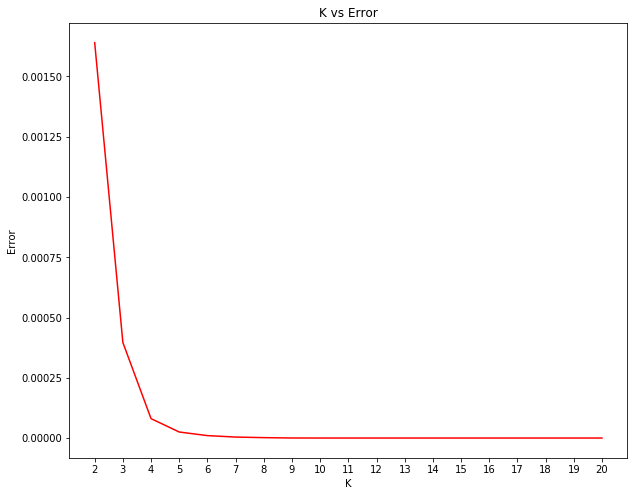

In [48]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

#### Moreover, in K-Means clustering, objects that are similar based on a certain variable are put into the same cluster. Neighbourhoods that had a similar mean frequency of Vegan/Vegetarian restaurant were divided into 4 clusters. Each of these clusters was labelled from 0 to 3 as the indexing of labels begins with 0 instead of 1.

In [49]:
kclusters = 4

toronto_grouped_clustering = vegan.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 1, 0])

##### We are going to create a new df that includes the cluster for each Neighborhood and the occurence of Vegan/Vegetarian Restaruant. 

In [50]:
# create a new dataframe 
to_merged = vegan.copy()

# add clustering labels
to_merged["ClusterLabels"] = kmeans.labels_

In [51]:
to_merged.head()

,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels
0,Agincourt,0.0,0
1,"Alderwood, Long Branch",0.0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0
3,Bayview Village,0.0,0
4,"Bedford Park, Lawrence Manor East",0.0,0


#### Now we are going to add info of latitude and longitude and the closest venues to each Neigborhood.This new table  would be the basis for analyzing new opportunities for opening a new Italian Restaurant in Toronto. 

In [52]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood. 
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2167, 9)


,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Agincourt,0.0,0,43.7942,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.7942,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.7942,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.7942,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
0,Agincourt,0.0,0,43.7942,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink


In [53]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["ClusterLabels"], inplace=True)
to_merged

(2167, 9)


,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Agincourt,0.000000,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
51,"Mimico NW, The Queensway West, South of Bloor,...",0.000000,0,43.628841,-79.520999,Value Village,43.631269,-79.518238,Thrift / Vintage Store
51,"Mimico NW, The Queensway West, South of Bloor,...",0.000000,0,43.628841,-79.520999,Once Upon A Child,43.631075,-79.518290,Kids Store
51,"Mimico NW, The Queensway West, South of Bloor,...",0.000000,0,43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
51,"Mimico NW, The Queensway West, South of Bloor,...",0.000000,0,43.628841,-79.520999,Royal Canadian Legion #210,43.628855,-79.518903,Social Club
...,...,...,...,...,...,...,...,...,...
75,Stn A PO Boxes,0.010417,3,43.646435,-79.374846,St. Lawrence Market Plaza,43.649169,-79.372330,Art Gallery
75,Stn A PO Boxes,0.010417,3,43.646435,-79.374846,Loaded Pierogi,43.647965,-79.373427,Comfort Food Restaurant
75,Stn A PO Boxes,0.010417,3,43.646435,-79.374846,Stonemill Bread,43.648668,-79.371610,Bakery
75,Stn A PO Boxes,0.010417,3,43.646435,-79.374846,Sukhothai,43.648487,-79.374547,Thai Restaurant


In [54]:
#Lets check how many Vegetarian/Vegan Restaurant are there

In [55]:
to_merged['VenueCategory'].value_counts()['Vegetarian / Vegan Restaurant']

16

In [56]:
to_merged['VenueCategory'].value_counts()['Yoga Studio']

13

#### We see that there are a total of 16 locations with Vegetarian Restaurants in Toronto
#### Then we will create a map using the Folium wher each neighbourhood was coloured based on their cluster label.
###### Cluster 0 — Red
###### CCluster 1 — Purple
###### CCluster 2 — Turquoise
###### CCluster 3— Green Khaki

In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['NeighborhoodLatitude'], to_merged['NeighborhoodLongitude'], to_merged['Neighborhood'], to_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

###### The map above shows the different clusters that had a similar mean frequency of Vegetarian/Vegan restaurants.

### How many Neighborhoods per Cluster?¶

In [58]:
vegan["Cluster Labels"] = kmeans.labels_
vegan.head(50)

,Neighborhood,Vegetarian / Vegan Restaurant,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.000000,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.000000,0
5,Berczy Park,0.018182,1
6,"Birch Cliff, Cliffside West",0.000000,0
7,"Brockton, Parkdale Village, Exhibition Place",0.000000,0
8,"Business reply mail Processing Centre, South C...",0.000000,0
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0


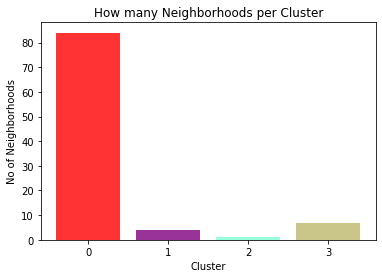

In [59]:
objects = (0,1,2,3)
y_pos = np.arange(len(objects))
performance = vegan['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()


In [60]:
# How many neighborhoods in each cluster
vegan['Cluster Labels'].value_counts()

0    84
3     7
1     4
2     1
Name: Cluster Labels, dtype: int64

# Analyzing each cluster

## CLUSTER 0

In [61]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough','Neighborhood']]
df_new.head()

,Borough,Neighborhood
0,Central Toronto,Lawrence Park
1,Central Toronto,Davisville North
2,Central Toronto,"North Toronto West, Lawrence Park"
3,Central Toronto,Davisville
4,Central Toronto,"Moore Park, Summerhill East"


In [62]:
# Red 

cluster0 = to_merged.loc[to_merged['ClusterLabels'] == 0]
df_cluster0 = pd.merge(df_new, cluster0, on='Neighborhood')
df_cluster0

,Borough,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
1,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
3,Central Toronto,Davisville North,0.0,0,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Central Toronto,Davisville North,0.0,0,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop
...,...,...,...,...,...,...,...,...,...,...
1279,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,High Park Brewery,43.669903,-79.483430,Brewery
1280,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,195 Jane Rocket,43.672335,-79.492634,Bus Line
1281,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,Wonderfood,43.672352,-79.492571,Convenience Store
1282,York,Weston,0.0,0,43.706876,-79.518188,Wallace C. Swanek Park,43.708896,-79.522648,Park


In [63]:
#Let's find out how many unique categories there are in cluster 0

print('There are {} uniques categories.'.format(len(df_cluster0['VenueCategory'].unique())))
df_cluster0['VenueCategory'].unique()

There are 225 uniques categories.


array(['Bus Line', 'Swim School', 'Park', 'Breakfast Spot',
       'Food & Drink Shop', 'Department Store', 'Hotel', 'Sandwich Place',
       'Gym / Fitness Center', 'Dog Run', 'Dance Studio', 'Spa',
       'Yoga Studio', 'Salon / Barbershop', 'Diner', 'Clothing Store',
       'Restaurant', 'Bagel Shop', 'Furniture / Home Store', 'Café',
       'Coffee Shop', 'Fast Food Restaurant', 'Sporting Goods Shop',
       'Chinese Restaurant', 'Mexican Restaurant', 'Ice Cream Shop',
       'Dessert Shop', 'Indian Restaurant', 'Pizza Place',
       'Seafood Restaurant', 'Sushi Restaurant', 'Italian Restaurant',
       'Thai Restaurant', 'Brewery', 'Gym', 'Toy / Game Store',
       'Greek Restaurant', 'Gas Station', 'Farmers Market',
       'Gourmet Shop', 'Candy Store', 'Pharmacy', 'Indoor Play Area',
       'Trail', 'Playground', 'Liquor Store', 'Supermarket',
       'American Restaurant', 'Light Rail Station', 'Bank',
       'Fried Chicken Joint', 'Vietnamese Restaurant', 'Pub', 'Dive Bar',
   

###  lets see how many  vegetarian restaurant and yoga studio are in cluster 0

In [64]:
"Vegetarian / Vegan Restaurant" in df_cluster0['VenueCategory'].unique()

False

In [65]:
"Yoga Studio" in df_cluster0['VenueCategory'].unique()

True

In [66]:
df_cluster0['VenueCategory'].value_counts()['Yoga Studio']

9

In [67]:
## Let´s see in which neighborhoods are situated this Yoga studio 
df0Y=df_cluster0[df_cluster0['VenueCategory']== 'Yoga Studio']
df0Y

,Borough,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
13,Central Toronto,"North Toronto West, Lawrence Park",0.0,0,43.715383,-79.405678,Barreworks,43.714070,-79.400109,Yoga Studio
191,Downtown Toronto,Church and Wellesley,0.0,0,43.665860,-79.383160,Bikram Yoga Yonge,43.668205,-79.385780,Yoga Studio
195,Downtown Toronto,Church and Wellesley,0.0,0,43.665860,-79.383160,The Yoga Sanctuary,43.661499,-79.383636,Yoga Studio
245,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
384,Downtown Toronto,"University of Toronto, Harbord",0.0,0,43.662696,-79.400049,Sivananda Yoga Centre,43.662754,-79.402951,Yoga Studio
453,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.0,0,43.662301,-79.389494,The Yoga Sanctuary,43.661499,-79.383636,Yoga Studio
498,East Toronto,"The Danforth West, Riverdale",0.0,0,43.679557,-79.352188,Moksha Yoga Danforth,43.677622,-79.352116,Yoga Studio
559,East Toronto,Studio District,0.0,0,43.659526,-79.340923,Spirit Loft Yoga,43.663548,-79.341333,Yoga Studio
666,East York,Thorncliffe Park,0.0,0,43.705369,-79.349372,Bikram Yoga East York,43.705450,-79.351448,Yoga Studio


## Cluster 1

In [74]:
cluster1 = to_merged.loc[to_merged['ClusterLabels'] == 1]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1

,Borough,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Downtown Toronto,Berczy Park,0.018182,1,43.644771,-79.373306,Scheffler's Deli,43.648643,-79.371537,Cheese Shop
1,Downtown Toronto,Berczy Park,0.018182,1,43.644771,-79.373306,Uno Mustachio,43.648702,-79.371540,Sandwich Place
2,Downtown Toronto,Berczy Park,0.018182,1,43.644771,-79.373306,Oyshi Sushi,43.642340,-79.375853,Sushi Restaurant
3,Downtown Toronto,Berczy Park,0.018182,1,43.644771,-79.373306,Brookfield Place,43.646791,-79.378769,Shopping Mall
4,Downtown Toronto,Berczy Park,0.018182,1,43.644771,-79.373306,Tim Hortons,43.647761,-79.370496,Coffee Shop
...,...,...,...,...,...,...,...,...,...,...
231,West Toronto,"Runnymede, Swansea",0.028571,1,43.651571,-79.484450,Supper Solved,43.648781,-79.485233,Restaurant
232,West Toronto,"Runnymede, Swansea",0.028571,1,43.651571,-79.484450,My Place - a Canadian Pub,43.648458,-79.485187,Pub
233,West Toronto,"Runnymede, Swansea",0.028571,1,43.651571,-79.484450,Classico,43.649194,-79.484699,Pizza Place
234,West Toronto,"Runnymede, Swansea",0.028571,1,43.651571,-79.484450,Cinelli,43.649916,-79.482146,Salon / Barbershop


In [75]:
#Let's find out how many unique categories there are in cluster 1

print('There are {} uniques categories.'.format(len(df_cluster1['VenueCategory'].unique())))
df_cluster1['VenueCategory'].unique()

There are 98 uniques categories.


array(['Cheese Shop', 'Sandwich Place', 'Sushi Restaurant',
       'Shopping Mall', 'Coffee Shop', 'Italian Restaurant',
       'Sporting Goods Shop', 'Diner', 'Beach', 'Japanese Restaurant',
       'Bagel Shop', 'Department Store', 'Bakery', 'Grocery Store',
       'Restaurant', 'Gourmet Shop', 'Hotel', 'Breakfast Spot', 'Pub',
       'Pharmacy', 'Eastern European Restaurant', 'Steakhouse',
       'Concert Hall', 'Vegetarian / Vegan Restaurant', 'Liquor Store',
       'Beer Bar', 'Museum', 'Thai Restaurant', 'Café',
       'Comfort Food Restaurant', 'Seafood Restaurant', 'Creperie',
       'Bistro', 'Tailor Shop', 'Greek Restaurant', 'Cocktail Bar',
       'Park', 'Farmers Market', 'Fountain', 'Basketball Stadium',
       'French Restaurant', 'Jazz Club', 'Fish Market', 'Art Gallery',
       'Food Truck', 'Gym', 'Deli / Bodega', 'Bookstore', 'Salad Place',
       'Tea Room', 'American Restaurant', 'Latin American Restaurant',
       'Burger Joint', 'Hotel Bar', 'Poke Place', 'Wine Bar

In [77]:

df_cluster1.sort_values(["Vegetarian / Vegan Restaurant"], ascending=False)

,Borough,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
235,West Toronto,"Runnymede, Swansea",0.028571,1,43.651571,-79.484450,Vescada,43.649980,-79.482252,Cosmetics Shop
218,West Toronto,"Runnymede, Swansea",0.028571,1,43.651571,-79.484450,Humber Cinema,43.649118,-79.484818,Indie Movie Theater
216,West Toronto,"Runnymede, Swansea",0.028571,1,43.651571,-79.484450,Java Joe's,43.650424,-79.479755,Café
215,West Toronto,"Runnymede, Swansea",0.028571,1,43.651571,-79.484450,Tim Hortons,43.648526,-79.485066,Coffee Shop
214,West Toronto,"Runnymede, Swansea",0.028571,1,43.651571,-79.484450,Heart,43.650310,-79.480125,Dessert Shop
...,...,...,...,...,...,...,...,...,...,...
34,Downtown Toronto,Berczy Park,0.018182,1,43.644771,-79.373306,Mos Mos,43.641640,-79.377552,Coffee Shop
33,Downtown Toronto,Berczy Park,0.018182,1,43.644771,-79.373306,Buster's Sea Cove,43.648495,-79.371462,Seafood Restaurant
32,Downtown Toronto,Berczy Park,0.018182,1,43.644771,-79.373306,Loaded Pierogi,43.647965,-79.373427,Comfort Food Restaurant
31,Downtown Toronto,Berczy Park,0.018182,1,43.644771,-79.373306,Balzac's Coffee,43.648457,-79.371790,Café


###  lets see how many  vegetarian restaurant and yoga studio are in cluster 1

In [78]:
"Vegetarian / Vegan Restaurant" in df_cluster1['VenueCategory'].unique()

True

In [79]:
df_cluster1['VenueCategory'].value_counts(ascending=False)['Vegetarian / Vegan Restaurant']

5

In [80]:
## Let´s see in which neighborhoods are these 5 vengan restaurant situated
df1V=df_cluster1[df_cluster1['VenueCategory']=='Vegetarian / Vegan Restaurant']
df1V

,Borough,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
25,Downtown Toronto,Berczy Park,0.018182,1,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
82,Downtown Toronto,"Commerce Court, Victoria Hotel",0.020000,1,43.648198,-79.379817,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
149,Downtown Toronto,"Commerce Court, Victoria Hotel",0.020000,1,43.648198,-79.379817,Rosalinda,43.650252,-79.385156,Vegetarian / Vegan Restaurant
181,West Toronto,"Little Portugal, Trinity",0.021739,1,43.647927,-79.419750,Veghed,43.649224,-79.422326,Vegetarian / Vegan Restaurant
221,West Toronto,"Runnymede, Swansea",0.028571,1,43.651571,-79.484450,Awai,43.650412,-79.478477,Vegetarian / Vegan Restaurant


In [81]:
"Yoga Studio" in df_cluster1['VenueCategory'].unique()

True

In [82]:
df_cluster1['VenueCategory'].value_counts()['Yoga Studio']

2

In [83]:
## Let´s see in which neighborhoods are situated this Yoga studio 
df1Y=df_cluster1[df_cluster1['VenueCategory']=='Yoga Studio']
df1Y

,Borough,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
162,West Toronto,"Little Portugal, Trinity",0.021739,1,43.647927,-79.41975,YogaSpace,43.647607,-79.420133,Yoga Studio
229,West Toronto,"Runnymede, Swansea",0.028571,1,43.651571,-79.48445,(The New) Moksha Yoga Bloor West,43.648658,-79.485242,Yoga Studio


## Cluster 2

In [84]:
# Blue
cluster2 = to_merged.loc[to_merged['ClusterLabels'] == 2]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2

,Borough,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Poetry Jazz Cafe,43.654975,-79.402371,Jazz Club
1,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Kensington College Backpackers Hostel,43.656837,-79.403203,Bed & Breakfast
2,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Trinity Common,43.656590,-79.402761,Bar
3,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Nom Nom Nom Poutine & Crêpes,43.652111,-79.404786,Poutine Place
4,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Pancho y Emiliano,43.654472,-79.401969,Mexican Restaurant
...,...,...,...,...,...,...,...,...,...,...
69,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Sonic Boom,43.650859,-79.396985,Record Shop
70,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Saigon Lotus Restaurant,43.654311,-79.399225,Vietnamese Restaurant
71,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,House of Jaffle,43.652053,-79.404867,Snack Place
72,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Wanda's Pie in the Sky,43.656163,-79.402630,Bakery


In [85]:
#Let's find out how many unique categories there are in cluster 2

print('There are {} uniques categories.'.format(len(df_cluster2['VenueCategory'].unique())))
df_cluster2['VenueCategory'].unique()

There are 49 uniques categories.


array(['Jazz Club', 'Bed & Breakfast', 'Bar', 'Poutine Place',
       'Mexican Restaurant', 'Furniture / Home Store', 'Café',
       'Burrito Place', 'Gaming Cafe', 'Organic Grocery', 'Bakery',
       'Cocktail Bar', 'Coffee Shop', 'Arts & Crafts Store',
       'Dessert Shop', 'Supermarket', 'Massage Studio',
       'Vietnamese Restaurant', 'Pharmacy', 'Breakfast Spot',
       'Smoothie Shop', 'Pizza Place', 'Hotel Bar', 'Grocery Store',
       'Park', 'Japanese Restaurant', 'Dim Sum Restaurant', 'Brewery',
       'Donut Shop', 'Hospital', 'Caribbean Restaurant', 'Burger Joint',
       'Ice Cream Shop', 'Filipino Restaurant',
       'Vegetarian / Vegan Restaurant', 'Doner Restaurant',
       'Dumpling Restaurant', 'Thai Restaurant', 'Food Court',
       'Farmers Market', 'Comfort Food Restaurant', 'Cheese Shop',
       'Wine Bar', 'Fish Market', 'Noodle House', 'Belgian Restaurant',
       'Beer Bar', 'Record Shop', 'Snack Place'], dtype=object)

###  lets see how many  vegetarian restaurant and yoga studio are in cluster 2

In [ ]:
"Vegetarian / Vegan Restaurant" in df_cluster2['VenueCategory'].unique()

In [86]:
df_cluster2['VenueCategory'].value_counts()['Vegetarian / Vegan Restaurant']

4

In [87]:
## Let´s see in which neighborhoods are these 5 vegan restaurant situated
df2V=df_cluster2[df_cluster2['VenueCategory']=='Vegetarian / Vegan Restaurant']
df2V

,Borough,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
43,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Greens Vegetarian Restaurant,43.652034,-79.402382,Vegetarian / Vegan Restaurant
50,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Urban Herbivore,43.656193,-79.402673,Vegetarian / Vegan Restaurant
51,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Buddha's Vegetarian,43.651904,-79.403312,Vegetarian / Vegan Restaurant
68,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.054054,2,43.653206,-79.400049,Hibiscus,43.655454,-79.402439,Vegetarian / Vegan Restaurant


In [88]:
"Yoga Studio" in df_cluster2['VenueCategory'].unique()

False

## CLUSTER 3

In [89]:
# Turquoise
cluster3 = to_merged.loc[to_merged['ClusterLabels'] == 3]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

,Borough,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Downtown Toronto,St. James Town,0.011765,3,43.651494,-79.375418,Pearl Diver,43.651481,-79.373600,Gastropub
1,Downtown Toronto,St. James Town,0.011765,3,43.651494,-79.375418,Crepe TO,43.650063,-79.374587,Creperie
2,Downtown Toronto,St. James Town,0.011765,3,43.651494,-79.375418,Hogtown Smoke,43.649287,-79.374689,Food Truck
3,Downtown Toronto,St. James Town,0.011765,3,43.651494,-79.375418,Triple A Bar (AAA),43.651658,-79.372720,BBQ Joint
4,Downtown Toronto,St. James Town,0.011765,3,43.651494,-79.375418,Mystic Muffin,43.652484,-79.372655,Middle Eastern Restaurant
...,...,...,...,...,...,...,...,...,...,...
644,Downtown Toronto,"First Canadian Place, Underground city",0.010000,3,43.648429,-79.382280,Equinox Bay Street,43.648100,-79.379989,Gym
645,Downtown Toronto,"First Canadian Place, Underground city",0.010000,3,43.648429,-79.382280,Hy's Steakhouse,43.649505,-79.382919,Steakhouse
646,Downtown Toronto,"First Canadian Place, Underground city",0.010000,3,43.648429,-79.382280,Adelaide Club Toronto,43.649279,-79.381921,Gym / Fitness Center
647,Downtown Toronto,"First Canadian Place, Underground city",0.010000,3,43.648429,-79.382280,Cactus Club Cafe,43.649552,-79.381671,American Restaurant


In [90]:
#Let's find out how many unique categories there are in cluster 3

print('There are {} uniques categories.'.format(len(df_cluster3['VenueCategory'].unique())))
df_cluster3['VenueCategory'].unique()

There are 144 uniques categories.


array(['Gastropub', 'Creperie', 'Food Truck', 'BBQ Joint',
       'Middle Eastern Restaurant', 'Coffee Shop', 'Gym', 'Café',
       'Restaurant', 'Theater', 'American Restaurant',
       'Japanese Restaurant', 'Thai Restaurant', 'Hotel', 'Camera Store',
       'Cosmetics Shop', 'Italian Restaurant', 'New American Restaurant',
       'Art Gallery', 'Seafood Restaurant', 'Electronics Store',
       'Fish Market', 'German Restaurant', 'Cheese Shop', 'Bookstore',
       'Lingerie Store', 'Beer Bar', 'Comfort Food Restaurant',
       'Clothing Store', 'French Restaurant', 'Grocery Store', 'Bakery',
       'Movie Theater', 'Diner', 'Latin American Restaurant',
       'Farmers Market', 'Cocktail Bar', 'Furniture / Home Store', 'Park',
       'Vegetarian / Vegan Restaurant', 'Fountain', 'Department Store',
       'Tailor Shop', 'Salon / Barbershop', 'Asian Restaurant',
       'Pharmacy', 'Moroccan Restaurant', 'Wine Bar', 'Irish Pub',
       'Breakfast Spot', 'Belgian Restaurant', 'Bistro',
  

###  lets see how many  vegetarian restaurant and yoga studio are in cluster 3

In [91]:
'Vegetarian / Vegan Restaurant' in df_cluster3['VenueCategory'].unique()

True

In [92]:
df_cluster3['VenueCategory'].value_counts()['Vegetarian / Vegan Restaurant']

7

In [93]:
## Let´s see in which neighborhoods are these 5 vegan restaurant situated
df3V=df_cluster3[df_cluster3['VenueCategory']=='Vegetarian / Vegan Restaurant']
df3V

,Borough,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
55,Downtown Toronto,St. James Town,0.011765,3,43.651494,-79.375418,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
85,Downtown Toronto,Central Bay Street,0.014706,3,43.657952,-79.387383,Vegetarian Haven,43.656016,-79.392758,Vegetarian / Vegan Restaurant
168,Downtown Toronto,"Richmond, Adelaide, King",0.010000,3,43.650571,-79.384568,Rosalinda,43.650252,-79.385156,Vegetarian / Vegan Restaurant
311,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",0.010000,3,43.640816,-79.381752,Kupfert & Kim,43.641179,-79.378144,Vegetarian / Vegan Restaurant
420,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",0.010000,3,43.647177,-79.381576,Rosalinda,43.650252,-79.385156,Vegetarian / Vegan Restaurant
509,Downtown Toronto,Stn A PO Boxes,0.010417,3,43.646435,-79.374846,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
582,Downtown Toronto,"First Canadian Place, Underground city",0.010000,3,43.648429,-79.382280,Rosalinda,43.650252,-79.385156,Vegetarian / Vegan Restaurant


In [94]:
"Yoga Studio" in df_cluster3['VenueCategory'].unique()

True

In [95]:
df_cluster3['VenueCategory'].value_counts()['Yoga Studio']

2

In [96]:
## Let´s see in which neighborhoods are situated this Yoga studio 
df3Y=df_cluster3[df_cluster3['VenueCategory']=='Yoga Studio']
df3Y

,Borough,Neighborhood,Vegetarian / Vegan Restaurant,ClusterLabels,NeighborhoodLatitude,NeighborhoodLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
120,Downtown Toronto,Central Bay Street,0.014706,3,43.657952,-79.387383,The Yoga Sanctuary,43.661499,-79.383636,Yoga Studio
482,Downtown Toronto,Stn A PO Boxes,0.010417,3,43.646435,-79.374846,Bikram Yoga Centre,43.649214,-79.375229,Yoga Studio


In [ ]:
clusters_mean = [df_cluster0['Vegetarian / Vegan Restaurant'].mean(),df_cluster1['Vegetarian / Vegan Restaurant'].mean(),df_cluster2['Vegetarian / Vegan Restaurant'].mean(),
                 df_cluster3['Vegetarian / Vegan Restaurant'].mean()]
objects = (0,1,2,3)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Vegetarian / Vegan Restaurant per Cluster')

plt.show()

#### Now that we have analyzed  all clustesr and we think that Church ans Wellesley, Regent Parck Habourfornt, University of Toronto, Harbour or Queens Park Ontario could be good Neighborhood to open a new vegan lets see the Most common venues of this neighborhood. 

In [97]:

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(96, 11)


,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Clothing Store,Event Space,Falafel Restaurant,Ethiopian Restaurant,Escape Room,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Coffee Shop,Pub,Pharmacy,Gym,Greek Restaurant,Discount Store,Department Store,Dessert Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Ice Cream Shop,Shopping Mall,Bridal Shop,Sandwich Place,Diner,Middle Eastern Restaurant,Restaurant
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Greek Restaurant,Thai Restaurant,Locksmith,Liquor Store,Comfort Food Restaurant,Juice Bar,Butcher
...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale West",Pizza Place,Grocery Store,Butcher,Coffee Shop,Pharmacy,Comic Shop,Diner,Ethiopian Restaurant,Escape Room,Electronics Store
92,Woburn,Coffee Shop,Mexican Restaurant,Korean BBQ Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
93,Woodbine Heights,Skating Rink,Curling Ice,Park,Intersection,Snack Place,Beer Store,Athletics & Sports,Dance Studio,Yoga Studio,Dog Run
94,York Mills West,Park,Convenience Store,Yoga Studio,Dumpling Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore


In [98]:
df_church=neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhoods']== 'Church and Wellesley']
df_church

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Church and Wellesley,Coffee Shop,Sushi Restaurant,Gay Bar,Japanese Restaurant,Restaurant,Mediterranean Restaurant,Café,Men's Store,Yoga Studio,Hotel


In [99]:
df_regent=neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhoods']=='Regent Park, Harbourfront']
df_regent

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,"Regent Park, Harbourfront",Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Spa,Brewery,Shoe Store


In [100]:
df_University=neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhoods']=='University of Toronto, Harbord']
df_University

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
84,"University of Toronto, Harbord",Café,Bookstore,Sandwich Place,Bakery,Bar,Japanese Restaurant,Noodle House,Bank,Italian Restaurant,Beer Bar


In [101]:
df_Queens=neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhoods']=="Queen's Park, Ontario Provincial Government"]
df_Queens

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,"Queen's Park, Ontario Provincial Government",Coffee Shop,Yoga Studio,Bank,Beer Bar,Smoothie Shop,Sandwich Place,Café,Restaurant,Chinese Restaurant,Portuguese Restaurant


##### 
According to the information in the data frame above we recommend opening the Vegan/Vegetarian Restaurant in Church and Wellesley or in Queen´s Park Ontario/Provincial Government. 
In both Neighborhoods there is a Yoga Studio as one of the most common venues and the type of client of Yoga studios are people normally open to trying and exploring vegetarian or vegan restaurants even if they do not follow a strictly vegan or vegetarian diet.
The other 10 most common venues are almost all restaurant or café which tells us that there are people looking for places to eat to whom we can give a different alternative to the restaurants that already exist.  
The  analysis does not take into consideration other  factors that would affect the success of a new restaurant which are directly related to the location such as visibility or accessibility so final decision between this two neighborhoods could depend also on the opportunity to find the best  suitable local to rent.
